# 適応信号処理（LMSアルゴリズム）ハンズオン

## 1. 準備：ライブラリと共通関数の定義
まずは必要なライブラリを読み込みます。BSSの時と同様、可視化用の関数もここで定義します。 レイアウトは「上段：学習曲線（エラーの推移）」、「中段：フィルタ係数の比較（中身の可視化）」、「下段：波形」とし、BSSデモの視認性を継承します。

In [1]:
# @title 1. システムの準備（ライブラリと可視化関数）
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from IPython.display import Audio, display

# --- 評価指標: MSE (Mean Squared Error) ---
def calc_mse_db(error_signal):
    mse = np.mean(error_signal**2)
    return 10 * np.log10(mse + 1e-10)

# --- 可視化用関数 ---
def plot_lms_results(error_log, w_true, w_est, d, y, e, fs, noise_level):
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

    col_true = '#1f77b4'  # 青
    col_est = '#ff7f0e'   # オレンジ
    col_err = '#2ca02c'   # 緑

    # --- 1段目: 学習曲線 ---
    ax1 = axes[0]
    window = 100
    if len(error_log) > window:
        smooth_curve = np.convolve(error_log, np.ones(window)/window, mode='valid')
        ax1.plot(smooth_curve, color=col_err, linewidth=2, label='Squared Error (Smoothed)')
    else:
        ax1.plot(error_log, color=col_err, alpha=0.6)

    # ノイズ分散（参考線）
    if noise_level > 0:
        theoretical_floor = noise_level**2
        ax1.axhline(theoretical_floor, color='gray', linestyle='--', label='Noise variance (σ²)')

    ax1.set_title("1. Learning Curve (Error Convergence)", fontsize=14)
    ax1.set_ylabel("Squared Error [Linear scale approx]")
    ax1.set_xlabel("Iterations (Time)")
    ax1.set_yscale('log')
    ax1.grid(True, which="both", ls=':', alpha=0.7)
    ax1.legend(loc='upper right')

    # --- 2段目: フィルタ係数比較 ---
    ax2 = axes[1]
    markerline, stemlines, baseline = ax2.stem(
        np.arange(len(w_true)), w_true,
        linefmt=col_true, markerfmt='bo', basefmt=" ", label='True System'
    )
    plt.setp(stemlines, 'linewidth', 2, 'alpha', 0.5)
    plt.setp(markerline, 'markersize', 8, 'alpha', 0.5)

    markerline2, stemlines2, baseline2 = ax2.stem(
        np.arange(len(w_est)) + 0.1, w_est,
        linefmt=col_est, markerfmt='ro', basefmt=" ", label='Estimated (LMS)'
    )
    plt.setp(stemlines2, 'linewidth', 2, 'color', col_est)
    plt.setp(markerline2, 'markersize', 6, 'color', col_est)

    ax2.set_title("2. Filter Weights Comparison", fontsize=14)
    ax2.set_xlabel("Tap Index")
    ax2.set_ylabel("Value")
    ax2.grid(True, ls=':', alpha=0.7)
    ax2.legend(loc='upper right')

    # --- 3段目: 波形 ---
    ax3 = axes[2]
    n_samples = len(d)
    plot_len = min(int(fs * 0.05), n_samples)
    time_axis = np.arange(n_samples - plot_len, n_samples) / fs

    ax3.plot(time_axis, d[-plot_len:], color=col_true, linewidth=2, alpha=0.5, label='Desired (w/ Noise)')
    ax3.plot(time_axis, y[-plot_len:], color=col_est, linestyle='--', linewidth=2, label='Output y(n)')
    ax3.plot(time_axis, e[-plot_len:], color=col_err, linewidth=1, alpha=0.8, label='Error e(n)')

    ax3.set_title(f"3. Waveforms (Final {plot_len} samples)", fontsize=14)
    ax3.set_xlabel("Time [s]")
    ax3.grid(True, ls=':', alpha=0.7)
    ax3.legend(loc='upper right')

    plt.suptitle("Adaptive Signal Processing Demo (LMS)", fontsize=20)
    plt.show()

print("準備完了。")

準備完了。


## 2. 未知のシステムと入力信号の生成ここでは、適応フィルタがコピーすべき「正解（未知のシステム）」を作ります。例えば、Web会議での「部屋の反響（エコー）」だと思ってください。適応フィルタは、この反響特性を学習することを目指します。$$d(n) = \mathbf{w}_{true}^T \mathbf{x}(n) + \text{noise}$$

未知のシステムを生成しました。（タップ数: 32）


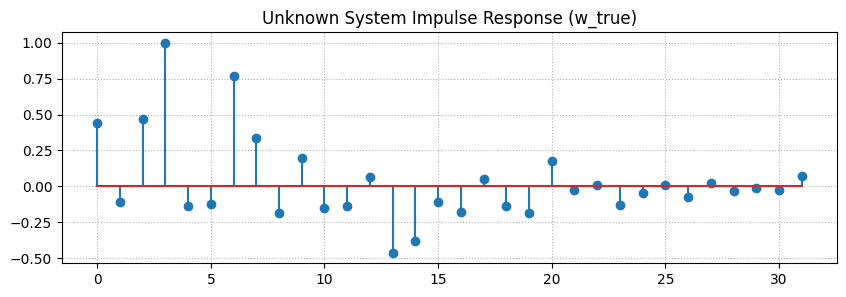

In [2]:
# @title 2. 未知のシステム(Target System)の生成
fs = 8000
filter_order = 32 # フィルタの長さ

# ランダムなシステムを作成
np.random.seed(42) # 再現性のため固定
w_true = np.random.randn(filter_order)
# 自然な減衰（インパルス応答）を与える
w_true *= np.exp(-np.arange(filter_order) / 10)
w_true /= np.max(np.abs(w_true)) # 正規化

print(f"未知のシステムを生成しました。（タップ数: {filter_order}）")
plt.figure(figsize=(10, 3))
plt.stem(w_true)
plt.title("Unknown System Impulse Response (w_true)")
plt.grid(True, ls=':')
plt.show()

## 3. LMSアルゴリズムの実装  
ここがこのシミュレーションの主役、LMSアルゴリズムです。数式は非常にシンプルです。  
1. フィルタ適用: $y(n) = \mathbf{w}^T(n) \mathbf{x}(n)$  
1. 誤差計算: $e(n) = d(n) -  y(n)$  
1. 係数更新: $\mathbf{w}(n+1) = \mathbf{w}(n) + \mu \cdot e(n) \cdot \mathbf{x}(n)$  

$\mu$ (ステップサイズ) が学習のスピードと安定性を決めます。  

スライダーで 「Noise Level (雑音の強さ)」 を調整できます。  

+ 実験のポイント:  
  + Noise Level = 0 のとき: 誤差（緑の線）はずっと下がり続けます。  
  + Noise Level > 0 のとき: 誤差はある一定のライン（ノイズフロア）で止まり、それ以上下がらなくなります。LMSは「システム」はコピーできても、「ランダムなノイズ」までは予測できないからです。  
  $$d(n) = \underbrace{\mathbf{w}_{true}^T \mathbf{x}(n)}_{\text{信号成分}} + \underbrace{\text{noise}(n)}_{\text{AWGN}}$$

Simulation Settings:
 - Step Size (mu): 0.01
 - Noise Level (std): 0.1 (SNR: 24.49 dB)
----------------------------------------
Final MSE (dB): -19.21570620674524


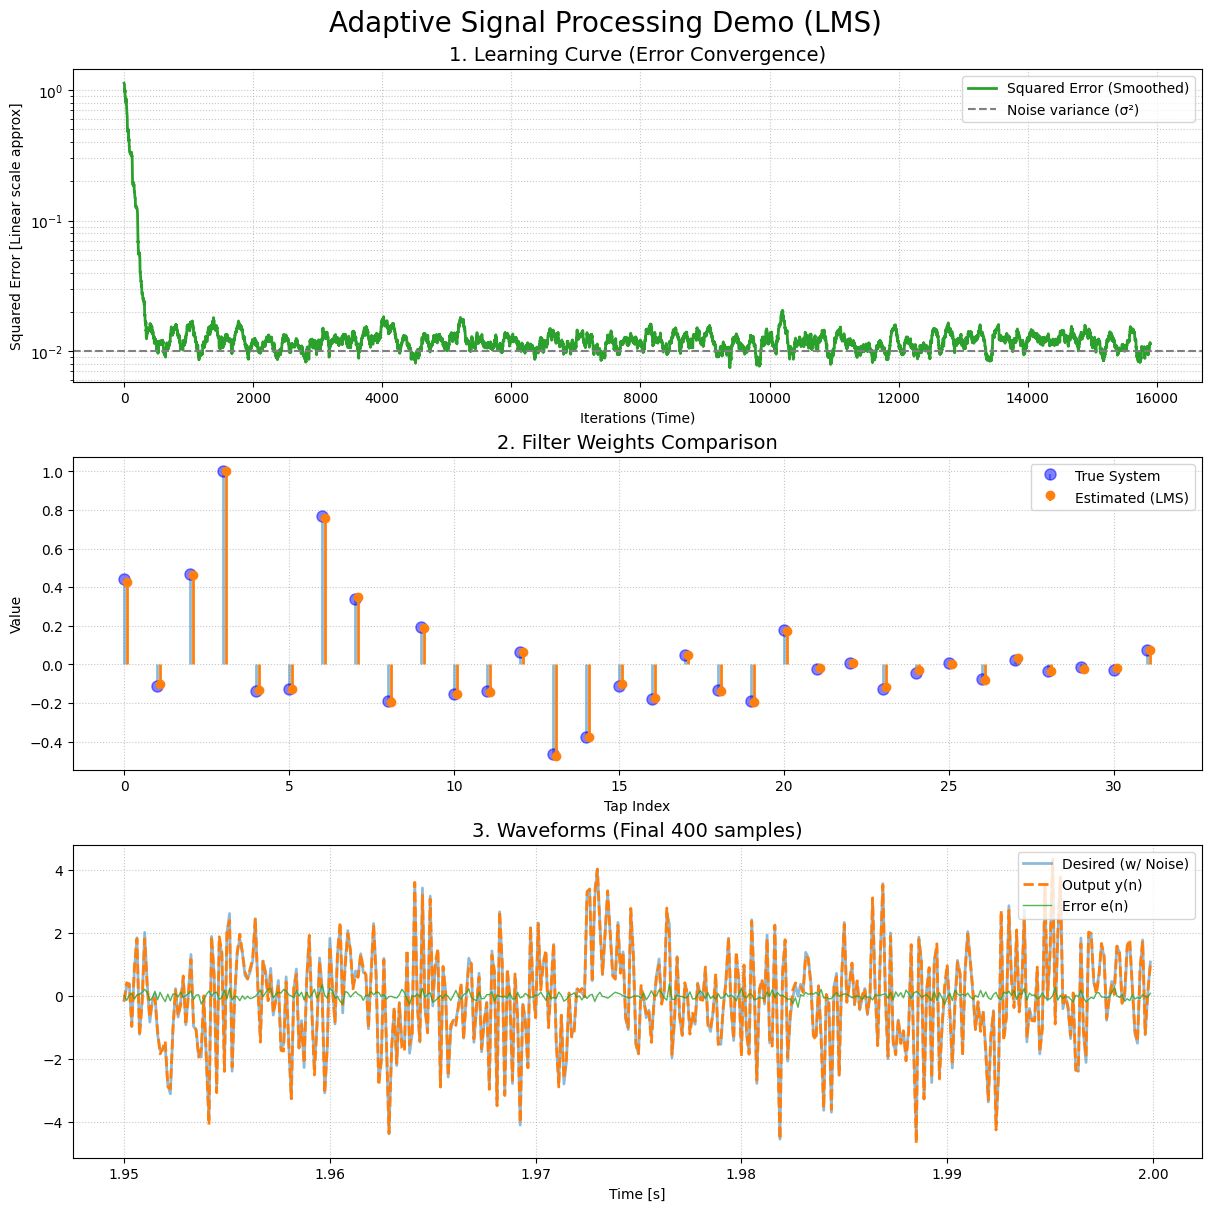


▼ Sound Check
1. Target Signal (d): System Response + Noise


2. LMS Output (y): Estimated Response


3. Error Signal (e): desired - output


In [3]:
# @title 3. シミュレーション実行 (パラメータ調整) { run: "auto" }

# --- パラメータ設定 ---
duration = 2.0
n_samples = int(fs * duration)

# ステップサイズ (学習率)
step_size_mu = 0.01 # @param {type:"slider", min:0.001, max:0.05, step:0.001}

# ノイズレベル (AWGNの標準偏差)
noise_std = 0.1 # @param {type:"slider", min:0.0, max:0.5, step:0.01}

# --- 信号生成 (Simulation Setup) ---
# 1. 入力信号 x(n): 白色雑音
np.random.seed(1) # 毎回同じ入力で比較するためseed固定
x = np.random.randn(n_samples)

# 2. 目標信号 d(n) の作成
# d(n) = (未知のシステムを通った音) + (ノイズ)
clean_signal = signal.lfilter(w_true, 1, x)

# AWGN (Additive White Gaussian Noise) の生成
noise = noise_std * np.random.randn(n_samples)
d = clean_signal + noise

# --- LMSアルゴリズム実行 ---
w = np.zeros(filter_order)
y = np.zeros(n_samples)
e = np.zeros(n_samples)
error_log = []
x_buffer = np.zeros(filter_order)

for n in range(n_samples):
    x_buffer = np.roll(x_buffer, 1)
    x_buffer[0] = x[n]

    y[n] = np.dot(w, x_buffer)
    e[n] = d[n] - y[n]

    # 係数更新
    w = w + step_size_mu * e[n] * x_buffer #LMS
    error_log.append(e[n]**2)

# --- 結果表示 ---
# SNRの計算と表示
signal_power = np.mean(clean_signal**2)
noise_power = np.mean(noise**2) + 1e-10
snr_db = 10 * np.log10(signal_power / noise_power)

print(f"Simulation Settings:")
print(f" - Step Size (mu): {step_size_mu}")
print(f" - Noise Level (std): {noise_std} (SNR: {snr_db:.2f} dB)")
print("-" * 40)

print("Final MSE (dB):", calc_mse_db(e[-2000:]))

# 可視化
plot_lms_results(error_log, w_true, w, d, y, e, fs, noise_std)

# 音声再生
print("\n▼ Sound Check")
print("1. Target Signal (d): System Response + Noise")
display(Audio(d, rate=fs))
print("2. LMS Output (y): Estimated Response")
display(Audio(y, rate=fs))
print("3. Error Signal (e): desired - output")
# ノイズが残っていることを確認する
display(Audio(e, rate=fs))

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>